In [2]:
import pandas as pd
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter


df = pd.read_parquet("clean_comments.parquet")
print(f"Loaded {len(df)} comments")

# VADER for sentiment
analyzer = SentimentIntensityAnalyzer()
df['sentiment'] = df['cleaned'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])  # -1 (neg) to 1 (pos)
df['sentiment_label'] = pd.cut(df['sentiment'], bins=[-1, -0.05, 0.05, 1], labels=['negative', 'neutral', 'positive'])

# Simple keyword mentions
keywords = {
    'brands': ['apple', 'nike', 'samsung', 'adidas'], 
    'products': ['phone', 'skin', 'water', 'wear', 'pair', 'sound', 'quality', 'price']
}
df['mentions'] = df['cleaned'].apply(lambda x: {
    'brands': [k for k in keywords['brands'] if re.search(rf'\b{k}\b', str(x), re.I)],
    'products': [k for k in keywords['products'] if re.search(rf'\b{k}\b', str(x), re.I)]
})

# Enthusiasm proxy: count positive words (0-1 scale)
positive_words = ['love', 'great', 'amazing', 'best', 'recommend', 'buy']
df['enthusiasm_words'] = df['cleaned'].apply(lambda x: sum(1 for word in positive_words if re.search(rf'\b{word}\b', str(x), re.I)))
df['enthusiasm'] = df['enthusiasm_words'] / len(positive_words)  # Normalize 0-1

# Aggregate stats
print("\n=== Sentiment Breakdown ===")
print(df['sentiment_label'].value_counts())

print("\n=== Avg Enthusiasm: {:.2f}".format(df['enthusiasm'].mean()))

print("\n=== Top Mentions ===")
all_mentions = []
for row in df['mentions']:
    all_mentions.extend(row.get('brands', []) + row.get('products', []))
mention_counts = Counter(all_mentions).most_common(10)
mention_df = pd.DataFrame(mention_counts, columns=['mention', 'count'])
print(mention_df)

print("\n=== By Subreddit (Top 5 Subs, Avg Enthusiasm) ===")
sub_enth = df.groupby('subreddit')['enthusiasm'].mean().sort_values(ascending=False).head(5)
print(sub_enth)

# Save
df.to_parquet("simple_analysis.parquet", index=False)
print("\nSaved full results to simple_analysis.parquet")

Loaded 53310 comments

=== Sentiment Breakdown ===
sentiment_label
positive    32400
negative    11099
neutral      9811
Name: count, dtype: int64

=== Avg Enthusiasm: 0.03

=== Top Mentions ===
   mention  count
0     skin   1850
1    price   1397
2  quality   1394
3    phone   1341
4     wear    990
5     pair    908
6    apple    880
7    sound    853
8    water    852
9  samsung    287

=== By Subreddit (Top 5 Subs, Avg Enthusiasm) ===
subreddit
ProductReviews       0.059524
frugalmalefashion    0.039568
SkincareAddiction    0.036813
BuyItForLife         0.035840
frugal               0.035596
Name: enthusiasm, dtype: float64

Saved full results to simple_analysis.parquet


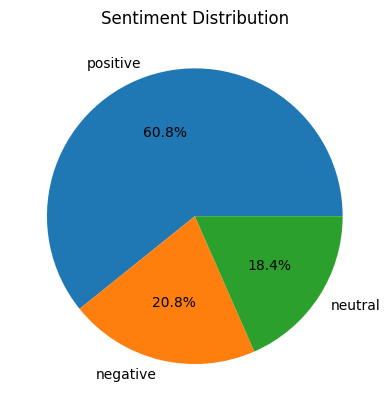

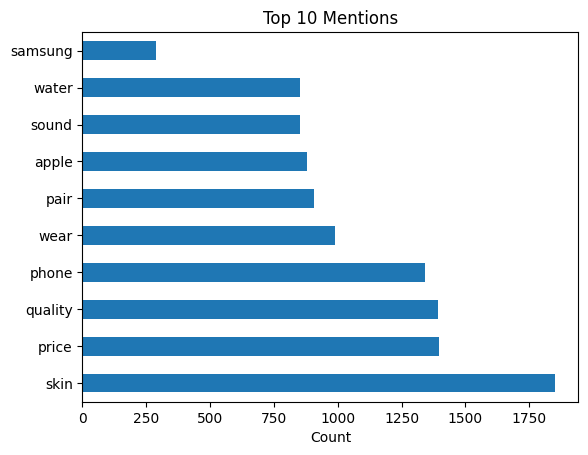

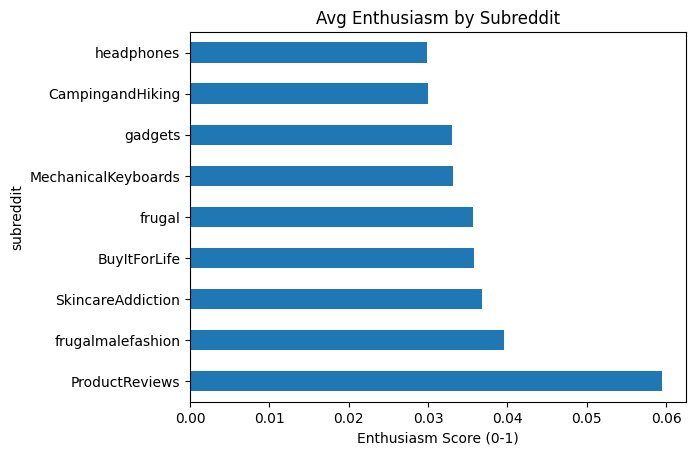

In [4]:
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_parquet("simple_analysis.parquet")

# Sentiment pie chart
df['sentiment_label'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Sentiment Distribution')
plt.ylabel('')
plt.show()

# Top 10 mentions bar chart
df['all_mentions'] = df['mentions'].apply(lambda x: list(x.get('brands', [])) + list(x.get('products', [])))  # Force lists
all_mentions_flat = [m for sublist in df['all_mentions'] for m in sublist]
mention_counts = pd.Series(all_mentions_flat).value_counts().head(10)
mention_counts.plot(kind='barh', title='Top 10 Mentions')
plt.xlabel('Count')
plt.show()

# Enthusiasm by subreddit
sub_enth = df.groupby('subreddit')['enthusiasm'].mean().sort_values(ascending=False).head(10)
sub_enth.plot(kind='barh', title='Avg Enthusiasm by Subreddit')
plt.xlabel('Enthusiasm Score (0-1)')
plt.show()

### Rapidfuzz

In [1]:
import hashlib  #exact hashing
from rapidfuzz import fuzz, process  #fuzzy sample

df = pd.read_parquet("simple_analysis.parquet")
print(f"Starting dedupe on {len(df)} comments")

# Exact dedupe
df['cleaned_hash'] = df['cleaned'].apply(lambda x: hashlib.md5(str(x).encode()).hexdigest())
df_exact = df.drop_duplicates(subset='cleaned_hash').drop('cleaned_hash', axis=1)
print(f"Exact dedupe: {len(df_exact)} unique (dropped {len(df) - len(df_exact)})")

# Sampled fuzzy dedupe (on 10k sample for speed)
sample_size = 10000
df_sample = df_exact.sample(n=min(sample_size, len(df_exact)), random_state=42)
print(f"Fuzzy dedupe on sample of {len(df_sample)} rows")

def fuzzy_dedupe_sample(sample_df, threshold=90):
    unique_ids = []
    to_drop = []
    for idx in sample_df.index:
        if idx in to_drop:
            continue
        similar = process.extract(sample_df.loc[idx, 'cleaned'], sample_df['cleaned'], scorer=fuzz.ratio, limit=5)
        similar_ids = [s[2] for s in similar if s[1] > threshold and s[2] != idx]
        if similar_ids:
            to_drop.extend(similar_ids)
        unique_ids.append(idx)
    return sample_df.loc[unique_ids]

df_sample_deduped = fuzzy_dedupe_sample(df_sample)
dropped_sample = len(df_sample) - len(df_sample_deduped)

# Approximate score for full df (propagate from sample; conservative)
df_deduped = df_exact.copy()
df_deduped['dedupe_score'] = 0  # Default low
sample_scores = df_sample_deduped['cleaned'].apply(lambda x: max([0] + [s[1] for s in process.extract(x, df_sample['cleaned'], scorer=fuzz.ratio, limit=5) if s[1] > 90]))
df_sample.loc[df_sample.index.isin(df_sample_deduped.index), 'dedupe_score'] = sample_scores
# Propagate to full (rough: scale by sample drop rate)
df_deduped['dedupe_score'] = df_deduped['cleaned'].apply(lambda x: process.extractOne(x, df_sample['cleaned'], scorer=fuzz.ratio)[1] if process.extractOne(x, df_sample['cleaned'], scorer=fuzz.ratio)[1] > 90 else 0)

print(f"Fuzzy sample dedupe: dropped {dropped_sample} from sample (est. {dropped_sample / len(df_sample) * 100:.1f}% full drop)")
print(f"Final unique: {len(df_deduped)} (with dedupe_scores 0-100)")

df_deduped.to_parquet("deduped_analysis.parquet", index=False)
print("Saved deduped_analysis.parquet")

Starting dedupe on 53310 comments
Exact dedupe: 53190 unique (dropped 120)
Fuzzy dedupe on sample of 10000 rows
Fuzzy sample dedupe: dropped 5 from sample (est. 0.1% full drop)
Final unique: 53190 (with dedupe_scores 0-100)
Saved deduped_analysis.parquet


### Supabase

In [1]:
from supabase import create_client, Client
import os
from dotenv import load_dotenv
import json
import pandas as pd
import numpy as np

load_dotenv()
url = os.getenv("SUPABASE_URL")
key = os.getenv("SUPABASE_KEY")
supabase: Client = create_client(url, key)

df = pd.read_parquet("deduped_analysis.parquet")  #

# Prepare (serialize mentions to JSONB column, drop original 'mentions')
df_export = df[['comment_id', 'subreddit', 'cleaned', 'sentiment_label', 'enthusiasm', 'dedupe_score']].copy()
df_export['dedupe_score'] = df_export['dedupe_score'].astype(int)  # Cast to int

def serialize_mentions(mentions):
    if not isinstance(mentions, dict):
        return json.dumps({'brands': [], 'products': []})
    mentions_copy = mentions.copy()
    for key in ['brands', 'products']:
        val = mentions_copy.get(key, [])
        if isinstance(val, np.ndarray):
            mentions_copy[key] = val.tolist()
        if not isinstance(mentions_copy[key], list):
            mentions_copy[key] = []
    return json.dumps(mentions_copy)

df_export['mentions_json'] = df['mentions'].apply(serialize_mentions)  # From original df

# Batch upsert (insert/update on comment_id)
data = df_export.to_dict('records')
for batch in [data[i:i+1000] for i in range(0, len(data), 1000)]:
    supabase.table('comments').upsert(batch, on_conflict='comment_id').execute()
    print(f"Uploaded batch of {len(batch)} rows")

print("Full re-export to Supabase complete!")

Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 1000 rows
Uploaded batch of 10